In [1]:
# Kuinka tehdä täydellinen analyysi asiakaskokemuksesta Twitter-viesteistä?
# Käytettävissä oli helmikuulta 2015 data, joka sisälsi noin 15 000 riviä tietoa.
# Twitter-viestien lähettäjinä olivat yhdysvaltalaisten lentoyhtiöiden asiakkaat heti asiakaskohtaamisen jälkeen.  

# Tuodaan kirjastot sisään.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Lähteenä mm. https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
# Tuodaan datat sisään.

df= pd.read_excel("Tweets_kasitelty.xlsx")
df.head()

,Määrä,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,7178,570000000000000000,positive,0.3499,NaN,0.0000,Delta,NaN,SeanUppercut,NaN,0,"""LOL you guys are so on it"" - me, had this bee...",NaN,2015-02-23 11:31:00,NaN,NaN
1,14473,570000000000000000,negative,0.6512,Customer Service Issue,0.6512,American,NaN,sarrraright,NaN,0,#nothelpful MT @AmericanAir: Our call volume i...,NaN,2015-02-22 15:42:00,NaN,Pacific Time (US & Canada)
2,7112,570000000000000000,neutral,1.0000,NaN,NaN,Delta,NaN,UAKShine,NaN,0,#Real RT @JetBlue: Our fleet's on fleek. http:...,NaN,2015-02-23 12:34:00,NaN,NaN
3,5051,570000000000000000,negative,0.6888,Bad Flight,0.3499,Southwest,NaN,danihampton,NaN,0,&lt,NaN,NaT,"palo alto, ca",Pacific Time (US & Canada)
4,7208,570000000000000000,neutral,0.6907,NaN,NaN,Delta,NaN,MelechT,NaN,4,*On the brink of bankruptcy. â€œ@JetBlue: Our ...,NaN,2015-02-23 11:14:00,this place called NYC,Eastern Time (US & Canada)


In [3]:
# Dataan tutustuminen, puuttuvien arvojen lukumäärät

print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14608, 16)
The number of nulls in each column are 
 Määrä                               0
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5456
negativereason_confidence        4113
airline                             0
airline_sentiment_gold          14576
name                                0
negativereason_gold             14584
retweet_count                       0
text                                0
tweet_coord                     13669
tweet_created                     966
tweet_location                   5403
user_timezone                    5474
dtype: int64


In [4]:
# Puuttuvien arvojen arviointi

print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


Määrä                            0.00
tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.35
negativereason_confidence       28.16
airline                          0.00
airline_sentiment_gold          99.78
name                             0.00
negativereason_gold             99.84
retweet_count                    0.00
text                             0.00
tweet_coord                     93.57
tweet_created                    6.61
tweet_location                  36.99
user_timezone                   37.47
dtype: float64

In [5]:
# Muuttujien poistaminen, joissa puuttuvat arvot ovat korkealla tasolla, yli 90 %

del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,Määrä,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,7178,570000000000000000,positive,0.3499,NaN,0.0000,Delta,SeanUppercut,0,"""LOL you guys are so on it"" - me, had this bee...",2015-02-23 11:31:00,NaN,NaN
1,14473,570000000000000000,negative,0.6512,Customer Service Issue,0.6512,American,sarrraright,0,#nothelpful MT @AmericanAir: Our call volume i...,2015-02-22 15:42:00,NaN,Pacific Time (US & Canada)
2,7112,570000000000000000,neutral,1.0000,NaN,NaN,Delta,UAKShine,0,#Real RT @JetBlue: Our fleet's on fleek. http:...,2015-02-23 12:34:00,NaN,NaN
3,5051,570000000000000000,negative,0.6888,Bad Flight,0.3499,Southwest,danihampton,0,&lt,NaT,"palo alto, ca",Pacific Time (US & Canada)
4,7208,570000000000000000,neutral,0.6907,NaN,NaN,Delta,MelechT,4,*On the brink of bankruptcy. â€œ@JetBlue: Our ...,2015-02-23 11:14:00,this place called NYC,Eastern Time (US & Canada)


Total number of tweets for each airline 
  airline
United            3805
US Airways        2910
American          2753
Southwest         2417
Delta             2220
Virgin America     503
Name: airline_sentiment, dtype: int64


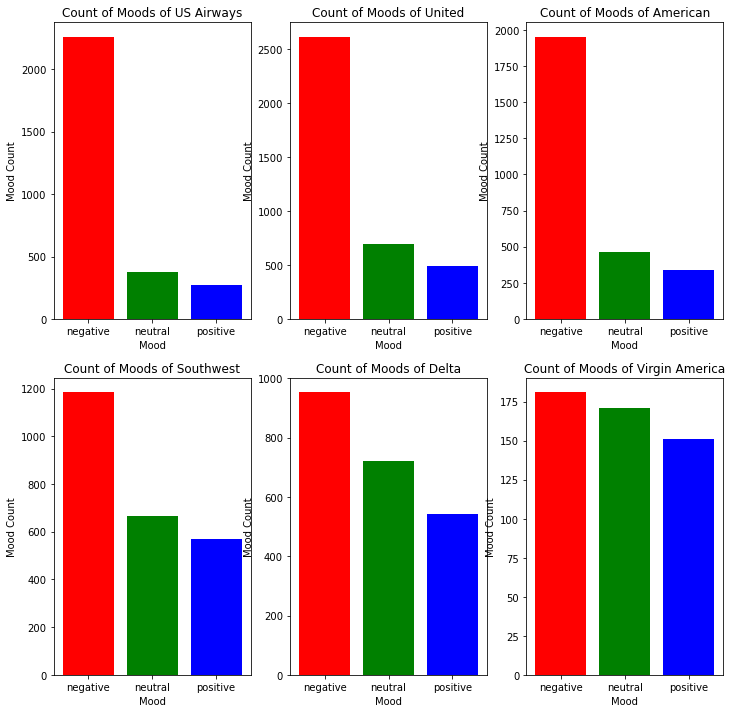

In [6]:
# Lasketaan ensiksi tviittien lukumäärät per lentoyhtiö 
# Lasketaan barplotit jokaiselle lentoyhtiölle (positive,negative or neutral)
# Kaikki lentoyhtiöt saivat kielteisiä reaktioita enemmän kuin neutraaleja tai positiviisia.
# Virgin America sai lähes yhtä paljon kaikkia reaktioita. Tviittien kokonaismäärä oli pienempi kuin muilla lentoyhtiöillä.

print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

In [7]:
# Tuodaan kirjastot sisään, useimmin käytetyt twiitit myönteiset ja kielteiset 
# Tavoite on saada näkemystä useimmin käytetyistä sanoista

from wordcloud import WordCloud,STOPWORDS

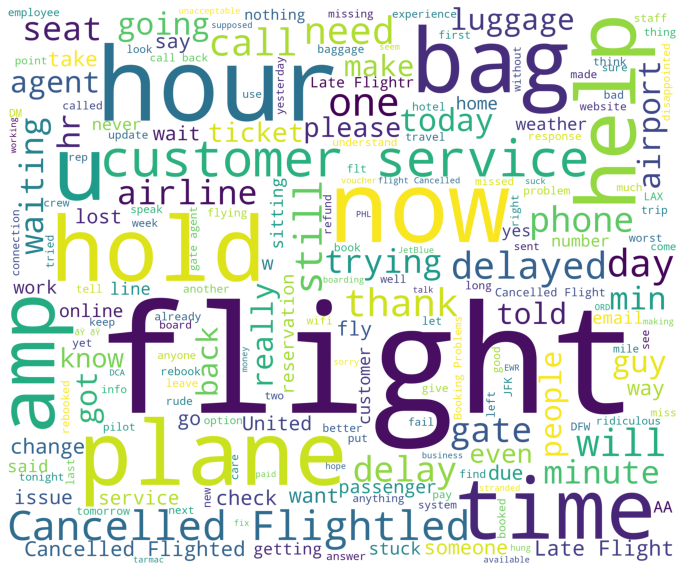

In [8]:
# Tehdään Wordcloud negatiivisista sentimenteistä.
# Wordcloud on hyvä työkalu visualisoida NLP dataa.
# Mitä suuremmat sanafontti, sitä suurempi frekvenssi on tekstidatassa. 

# Sanat kuten Cancelled, bag, delay, plane, hold, time ovat yleisimpien joukossa.
# Mutta joukossa on myös sanoja, jotka eivät välttämättä tarkoita mitään.

new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


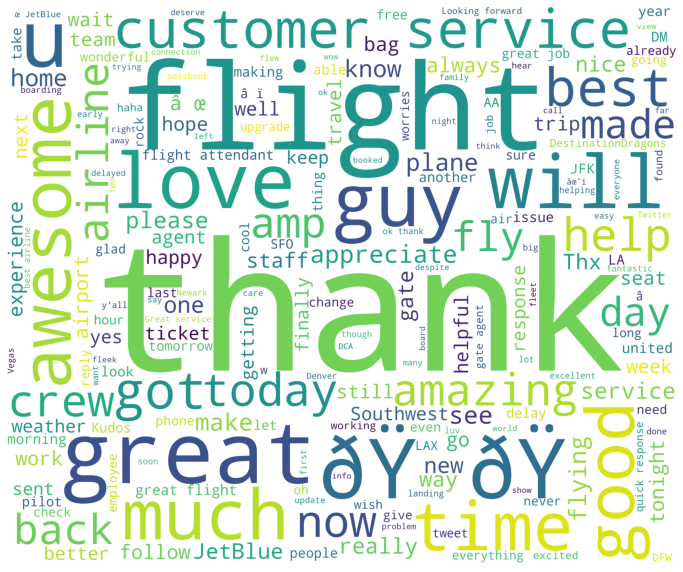

In [9]:
# Tehdään Wordcloud positiivisista sentimenteistä.
# Wordcloud on hyvä työkalu visualisoida NLP dataa.
# Mitä suuremmat sanafontti, sitä suurempi frekvenssi on tekstidatassa. 

# Sanat kuten Thanks, best, customer, love, flying , good ovat yleisimpien joukossa.
# Mutta joukossa on myös sanoja, jotka eivät välttämättä tarkoita mitään.

new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

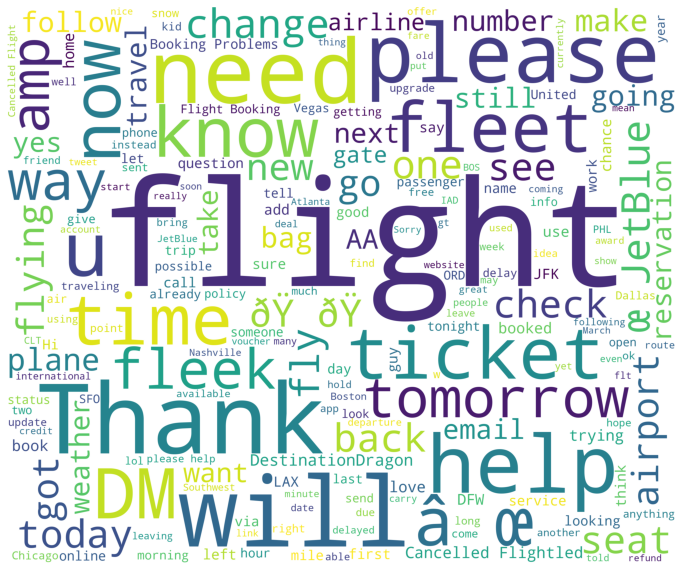

In [10]:
# Tehdään Wordcloud neutraalisista sentimenteistä.
# Wordcloud on hyvä työkalu visualisoida NLP dataa.
# Mitä suuremmat sanafontti, sitä suurempi frekvenssi on tekstidatassa. 

# Sanat kuten Thank, flight, ticket, change ovat yleisimpien joukossa.
# Mutta joukossa on myös sanoja, jotka eivät välttämättä tarkoita mitään.

new_df=df[df['airline_sentiment']=='neutral']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
# Lasketaan frekvenssit

# Sanat kuten flight, cancelled, change ovat yleisimpien joukossa.
# Mutta joukossa on myös sanoja, jotka eivät välttämättä tarkoita mitään.
# Suurin osa on niin sanottuja stop-sanoja, jotka pitää filtteröidä pois.

def freq(str): 
  
    # break the string into list of words  
    str = str.split()          
    str2 = [] 
  
    # loop till string values present in list str 
    for i in str:              
  
        # checking for the duplicacy 
        if i not in str2: 
  
            # insert value in str2 
            str2.append(i)  
              
    for i in range(0, len(str2)): 
        if(str.count(str2[i])>50): 
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))
        
print(freq(cleaned_word))

Frequency of Our is : 104
Frequency of fleet's is : 101
Frequency of on is : 616
Frequency of fleek. is : 101
Frequency of the is : 904
Frequency of of is : 329
Frequency of â€œ@JetBlue: is : 70
Frequency of Can is : 96
Frequency of you is : 621
Frequency of for is : 572
Frequency of this is : 171
Frequency of be is : 214
Frequency of Is is : 72
Frequency of your is : 144
Frequency of just is : 126
Frequency of so is : 108
Frequency of know is : 96
Frequency of to is : 1599
Frequency of will is : 165
Frequency of like is : 69
Frequency of a is : 752
Frequency of and is : 435
Frequency of I is : 1078
Frequency of about is : 80
Frequency of that is : 193
Frequency of - is : 171
Frequency of please is : 109
Frequency of me is : 248
Frequency of it is : 257
Frequency of in is : 426
Frequency of my is : 474
Frequency of need is : 127
Frequency of up is : 56
Frequency of now is : 67
Frequency of fly is : 67
Frequency of is is : 387
Frequency of if is : 143
Frequency of do is : 201
Frequency 

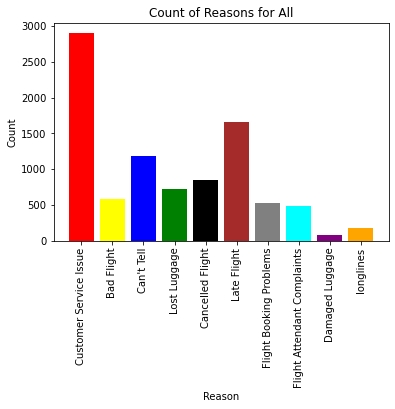

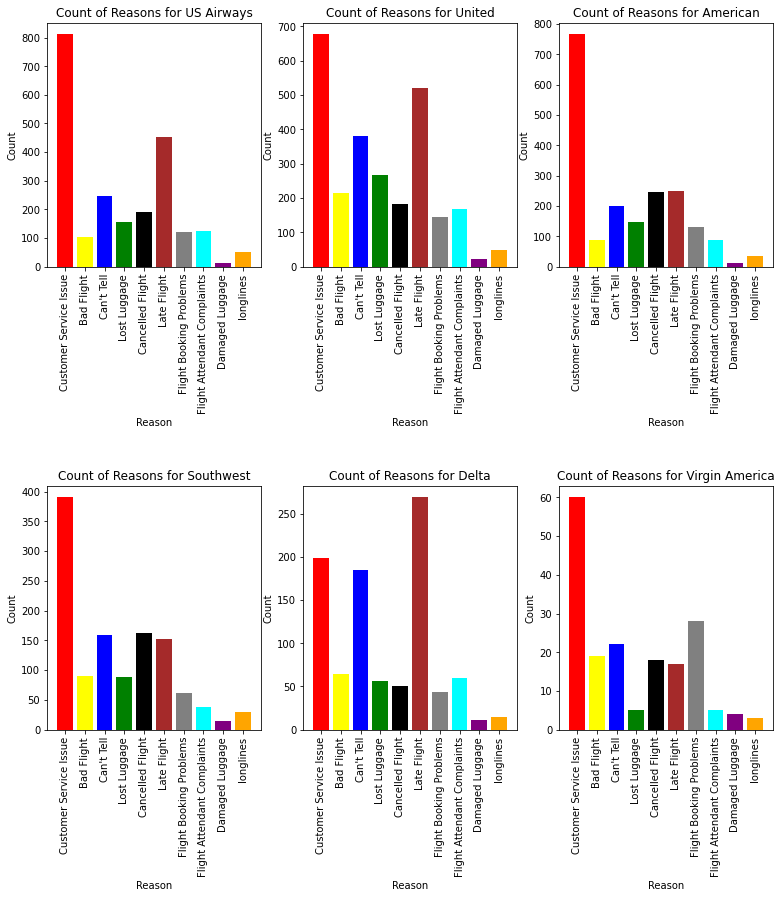

In [12]:
# Lasketaan seuraavaksi yleisimmät syyt kielteisistä sentimenteistä.

# Yksittäinen asiakaspalvelun aihe oli yleisin kielteinen syy US Airways, United, American, Southwest, Virgin America-aineistoissa.
# Toiseksi yleisin syy oli lennon myöhästyminen. 
# Kolmanneksi yleisin syy oli se, että vastaaja ei kyennyt kertomaan tarkkaa syytä kielteiselle asiakaskokemukselle. 
# Neljänneksi yleisin syy oli peruuntunut lento.
# Viidenneksi kadonneet matkatavarat lennon aikana. 

# Late Flight oli yleisin kielteinen syy Deltalle.
# Virgin America sai vähiten kielteisiä syitä.
# Toisaalta US Airways, United, American saivat yli 500 kielteistä syytä (Customer Service Issue).

#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [13]:
# Katsotaan, onko päivämäärällä yhteyttä kielteisiin sentimentteihin. 
# Tämä näyttää sentimentit ajanjaksolle 2015-02-16 to 2015-02-24 kullekin lentoyhtiölle.

date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
pd.set_option("max_columns", 2) #Showing only two columns
pd.set_option("max_rows", None)
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative              96
                               neutral               85
                               positive              65
               Southwest       negative             194
                               neutral               80
                               positive              83
               US Airways      negative             222
                               neutral               28
                               positive              40
               United          negative             254
                               neutral               70
                               positive              45
               Virgin America  negative              12
                               neutral               17

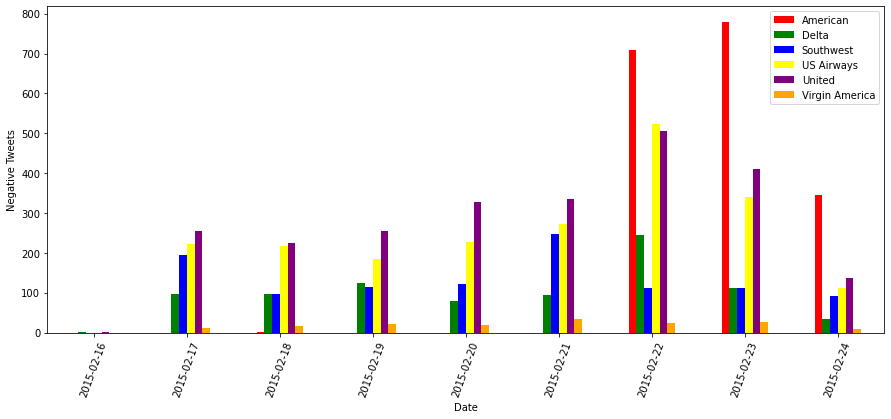

In [14]:
# Plotataan seuraavaksi sentimentit ajanjaksoille.
# Kiinnostavaa on se, että American-yhtiöllä negatiivinen sentimentti nousi jyrkästi 2015-02-23, joka puolittui 2015-02-24. 
# Virgin America -yhtiöllä on vähiten kielteisiä tviittejä, pitää kuitenkin muistaa, että Virgin Americalla on tviittejä vähiten kokonaismäärältää suhteessa muihin.
# Kielteisten tviittien määrä on vinoutunut loppuviikosta. 16.2.2015 on maanantai ja 22.2.2015 on sunnuntai.

day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()